# Regression functions

In [57]:
# These functions can be used to fit the models.
# You can change anything you want and you can use and add your own functions.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def poly_basis_transform(X,k):
    """
    X: one dimensional input array
    k: order of polynomial
    
    returns
    PHI: data matrix with polynomial features
    """
    X = np.array(X)
    m = X.size
    PHI = np.ones((m,k+1))
    for i in range(k+1):
        PHI[:,i] = np.power(X,i)
    return PHI


def mse(PHI,y,w):
    """
    PHI: augmented feature matrix
    y:   output vector
    w:   weight vector
    
    returns mean squared error
    """
    m = PHI.shape[0]
    return 1/(2*m) * np.linalg.norm(PHI.dot(w) - y)**2


def linear_eval(PHI,w):
    """
    PHI: augmented feature matrix
    w:   weight vector
    
    returns: array of linear hypothesis evaluations h(x) for all examples x in PHI
    """
    return PHI.dot(w)


def linear_regression_fit(PHI,y,n_iter,eta,lamb=0,w_init=None):
    """
    PHI:    augmented feature matrix
    y:      output vector
    n_iter: number of gradient descent iterations
    eta:    learning rate
    lamb:   regularization parameter
    w_init: initial weights
    
    returns
    w:    fitted weight vector
    loss: list of MSE values for each iteration
    """
    (m,k) = PHI.shape
    
    if w_init is None:
        w_init = 0.1*np.random.randn(k)
    
    w = w_init
    loss = [mse(PHI,y,w)] # first entry of loss is error with respect to initial weights
    
    for i in range(n_iter):
        w0 = w.copy()
        w0[0] = 0     # exclude bias from regularization
        grad = 1/m * (PHI.T.dot(PHI.dot(w) - y) + lamb*w0)
        w = w - eta*grad
        loss.append(mse(PHI,y,w))
        
    return w,loss

# Exercise 3.1

Generate	a	training	set	with	𝑚	examples.

In [58]:
f = lambda x: x[0]*np.sin(np.pi*x[1])

In [59]:
def gen_train(m,func):
    """
    m:    number	of	training	examples
    returns
    x:    independent	 samples from the	 uniform	 distribution
    y:    corresponding	output	values
    """
    x = np.random.uniform(-1,1,(m,2))
    return x, np.apply_along_axis(func, 1, x)

In [60]:
gnz = pd.read_csv("f31.csv",delimiter=";", header=None)
X_test = gnz.iloc[:,0:1]
y_test = gnz.iloc[:,2]

In [61]:
res = []
for m in range(2,80):
    merror = []
    for i in range(100):
        X_train, y_train = gen_train(m,f)

        PHI = np.ones((m,2+1))
        PHI[:,1:] = X_train

        w,loss = linear_regression_fit(PHI,y_train,200,0.01)
        train_error = mse(PHI,y_train,w)
        
        G_PHI = np.ones((X_test.shape[0],2+1))
        G_PHI[:,1:] = X_test

        test_error = mse(G_PHI,y_test,w)
        merror.append([train_error,test_error])
    
    merror = np.array(merror)
    merror = merror.mean(axis=0)/merror.shape[0]
    res.append([m,merror[0],merror[1]])
    
res = np.array(res)

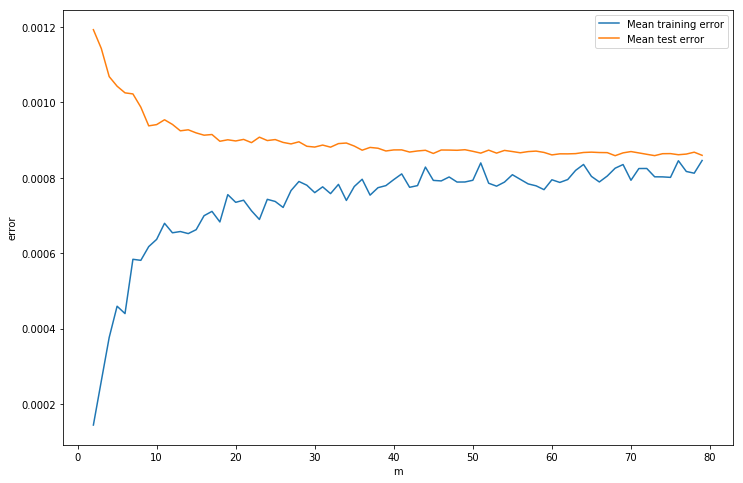

In [62]:
plt.figure(figsize=(12,8))
plt.plot(res[:,0],res[:,1],label="Mean training error")
plt.plot(res[:,0],res[:,2],label="Mean test error")
plt.xlabel("m")
plt.ylabel("error")
plt.legend()

# Exercise 3.2

# 1.

In [70]:
train = pd.read_csv("f32train.csv",delimiter=";", header=None)
X_train = train.iloc[:,0]
y_train = train.iloc[:,1]

In [71]:
test = pd.read_csv("f32test.csv",delimiter=";", header=None)
X_test = test.iloc[:,0]
y_test = test.iloc[:,1]

In [75]:
res = []
for k in range(1,11):
    
    ### train
    PHI = poly_basis_transform(X_train,k)
    w, loss = linear_regression_fit(PHI,y_train,20000,0.1)
    mse_train = mse(PHI,y_train,w)
    ##########
    
    ### test
    PHI = poly_basis_transform(X_test,k)
    mse_test = mse(PHI,y_test,w)
    ##########
    
    res.append([k,mse_train,mse_test])
    
res_1 = np.array(res)
#res_1[:,1] /= res_1.shape[0]
#res_1[:,2] /= res_1.shape[0]
print(res_1)

[[ 1.          5.43259102  5.37800447]
 [ 2.          5.4324118   5.37769177]
 [ 3.          4.33048815  4.50959177]
 [ 4.          4.27829381  4.57119992]
 [ 5.          1.0379643   0.97553786]
 [ 6.          1.04615028  0.98351544]
 [ 7.          1.06737916  1.07524637]
 [ 8.          1.04642274  1.09234102]
 [ 9.          1.24260065  1.33327105]
 [10.          1.2220328   1.37790471]]


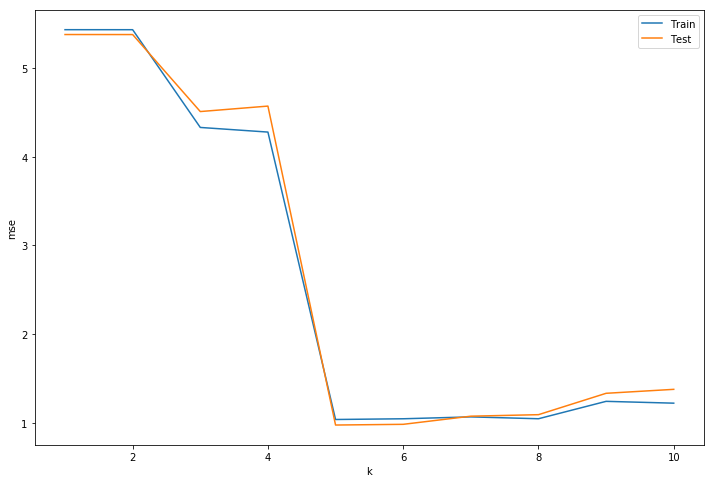

In [76]:
plt.figure(figsize=(12,8))
plt.plot(res_1[:,0],res_1[:,1],label="Train")
plt.plot(res_1[:,0],res_1[:,2],label="Test")
plt.xlabel("k")
plt.ylabel("mse")
plt.legend()

# 2.

In [77]:
def cross_val(X, y, folds, train, test, param=None,show_mask=False):
    # find shape
    shape = X.shape[0] - X.shape[0]%folds
    
    X = X[:shape].reshape((folds,-1))
    y = y[:shape].reshape((folds,-1))
    
    ret = []
    for i in range(folds):
        mask = np.ones(folds).astype(bool)
        mask[i] = False
        
        if show_mask: print(mask)
        
        X_test = X[~mask].flatten()
        y_test = y[~mask].flatten()
        X_train = X[mask].flatten()
        y_train = y[mask].flatten()
        ret.append(test(X_test, y_test, train(X_train, y_train,param), param))
    return ret

def train(X,y,param):
    k, it, eta, l2 = param
    PHI = poly_basis_transform(X,k)
    w, loss = linear_regression_fit(PHI,y,it,eta,lamb=l2)
    mse_train = mse(PHI,y,w)
    return w, loss, mse_train

def test(X, y, ret, param):
    k, it, eta, l2 = param
    w, loss, mse_train = ret
    PHI = poly_basis_transform(X,k)
    mse_test = mse(PHI,y,w)
    return w, mse_train, mse_test


X_ = np.array(X_train)
y_ = np.array(y_train)

res = [] 
for k in range(1,11):
    error = cross_val(X_,y_,10,train,test,[k,30000,0.1,0],k==1)
    error = np.array(error)
    avg = np.average(error[:,1:], axis=0)
    res.append([k, avg[0], avg[1]])

res_2 = np.array(res)
print(res_2)

[False  True  True  True  True  True  True  True  True  True]
[ True False  True  True  True  True  True  True  True  True]
[ True  True False  True  True  True  True  True  True  True]
[ True  True  True False  True  True  True  True  True  True]
[ True  True  True  True False  True  True  True  True  True]
[ True  True  True  True  True False  True  True  True  True]
[ True  True  True  True  True  True False  True  True  True]
[ True  True  True  True  True  True  True False  True  True]
[ True  True  True  True  True  True  True  True False  True]
[ True  True  True  True  True  True  True  True  True False]
[[ 1.          5.42244021  5.62783289]
 [ 2.          5.41170041  5.83374294]
 [ 3.          4.30146503  4.91357916]
 [ 4.          4.23861472  5.10493403]
 [ 5.          0.75955837  0.85621484]
 [ 6.          0.75937632  0.85244655]
 [ 7.          1.00266807  1.20212885]
 [ 8.          0.97631293  1.16380847]
 [ 9.          1.08888039  1.28178461]
 [10.          1.07629091  1.

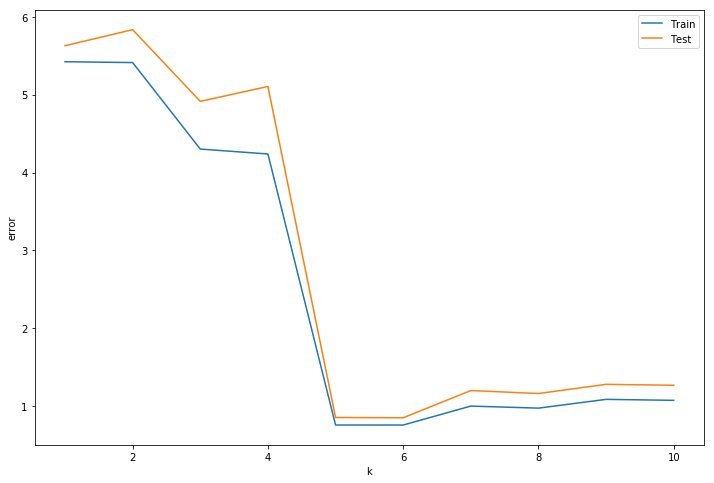

In [78]:
plt.figure(figsize=(12,8))
plt.plot(res_2[:,0],res_2[:,1],label="Train")
plt.plot(res_2[:,0],res_2[:,2],label="Test")
plt.xlabel("k")
plt.ylabel("error")
plt.legend()

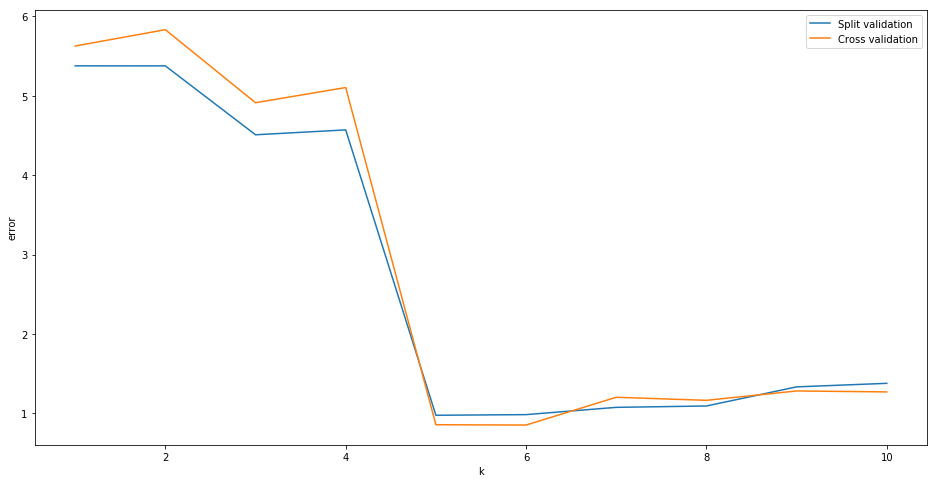

In [79]:
plt.figure(figsize=(16,8))
plt.plot(res_1[:,0],res_1[:,2],label="Split validation")
plt.plot(res_2[:,0],res_2[:,2],label="Cross validation")
plt.xlabel("k")
plt.ylabel("error")
plt.legend()

# Exercise 3.3

In [44]:
f33 = pd.read_csv("f33.csv",delimiter=";", header=None)
X_f33 = np.array(f33.iloc[:,0])
y_f33 = np.array(f33.iloc[:,1])

print(X_f33.shape)
print(y_f33.shape)

(20,)
(20,)


In [45]:
def train_inner(X,y,param):
    return train(X,y,param)
    
def test_inner(X, y, ret, param):
    return test(X, y, ret, param)

def train_outer(X,y,param):
    k, it, eta, l2, inner  = param
    
    # array w, mse_train, mse_test
    ret = cross_val(X, y, inner, train_inner, test_inner, param[:-1], show_mask=False)
    ret = np.array(ret)
    
    mse_train_min = ret[:,1].argmin()
    w = ret[mse_train_min,0]
    
    mse_train = ret[:,1].mean()
    
    return w, None, mse_train

def test_outer(X, y, ret, param):
    k, it, eta, l2, inner = param
    w, loss, mse_train = ret
    PHI = poly_basis_transform(X,k)
    mse_test = mse(PHI,y,w)
    return mse_train, mse_test

l2 = [0.001, 0.01, 0.1, 1, 10]
res = []

for l in l2:
    error = cross_val(X_f33, y_f33 ,5 ,train_outer ,test_outer ,[10,50000,0.1,l,5], False)
    error = np.array(error)
    avg = np.average(error, axis=0)
    res.append([l, avg[0], avg[1]])

res = np.array(res)

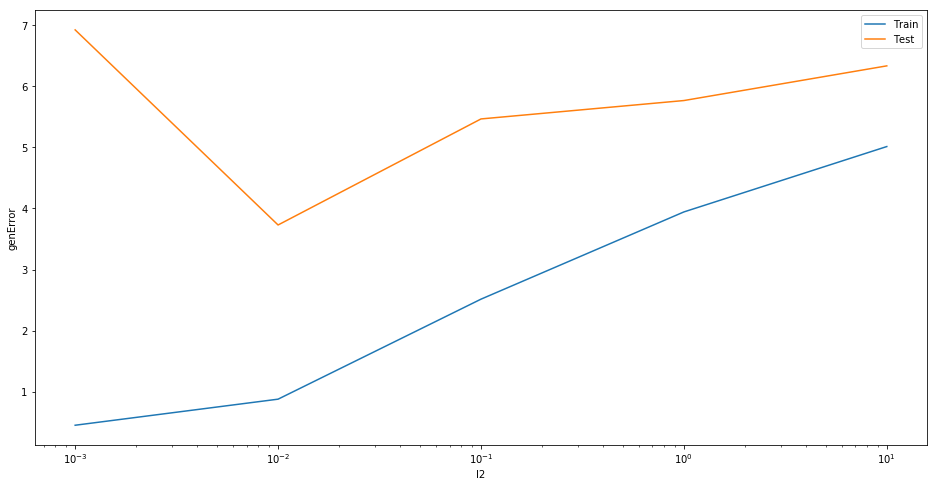

In [46]:
plt.figure(figsize=(16,8))
plt.plot(res[:,0],res[:,1],label="Train")
plt.plot(res[:,0],res[:,2],label="Test")
plt.xlabel("l2")
plt.ylabel("genError")
plt.xscale("log")
plt.legend()